## Problem Statement

Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.

As a starting point, ninjacart has provided us with a dataset scraped from the web which contains train and test folders, each having 4 sub-folders with images of onions, potatoes, tomatoes and some market scenes. We have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.

## Import Libraries and Load Data

importing the necessary libraries such as TensorFlow/Keras for model building, Matplotlib/Seaborn for visualization, and OpenCV/PIL for image processing.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report


## Load and Visualize Dataset

Load the dataset from the specified directories and visualize a few images from each category using PIL for image loading and matplotlib for plotting

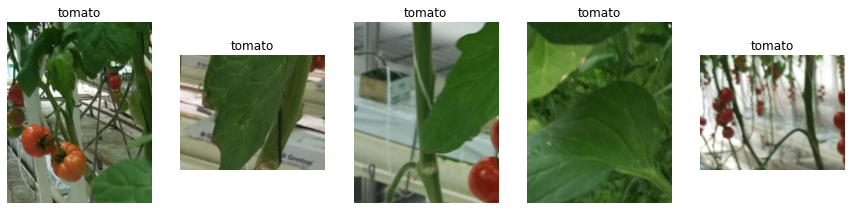

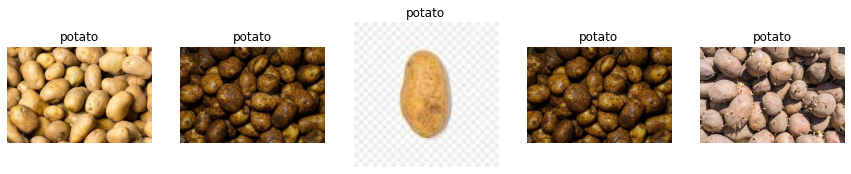

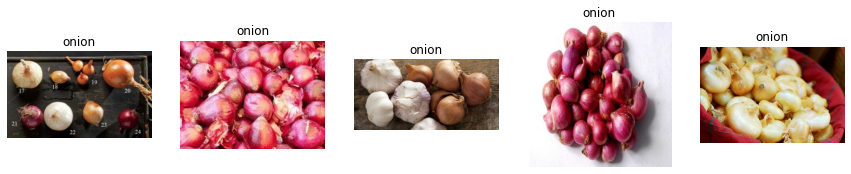

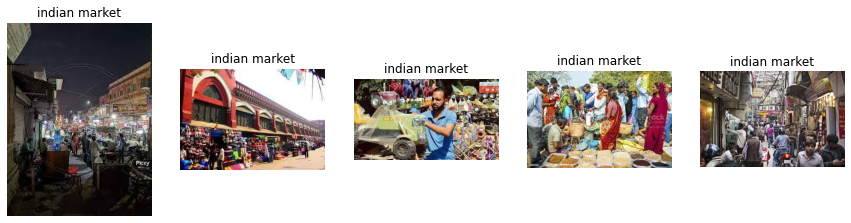

In [2]:
# Define dataset paths
train_dir = 'E:/1.SCALER/Classes/BusinessCase Studies/16.Business Case Ninjacart CV Classification/ninjacart_data/train'
test_dir = 'E:/1.SCALER/Classes/BusinessCase Studies/16.Business Case Ninjacart CV Classification/ninjacart_data/test'

# Categories
categories = ['tomato', 'potato', 'onion', 'indian market']

# Visualize some images from each category
def visualize_images_from_category(category, n_images=5):
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)[:n_images]
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n_images, i+1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

for category in categories:
    visualize_images_from_category(category)


## Data Preparation

#### .Check Image Dimensions
#### . Rescale Images
#### . Split Data into Train/Validation Sets

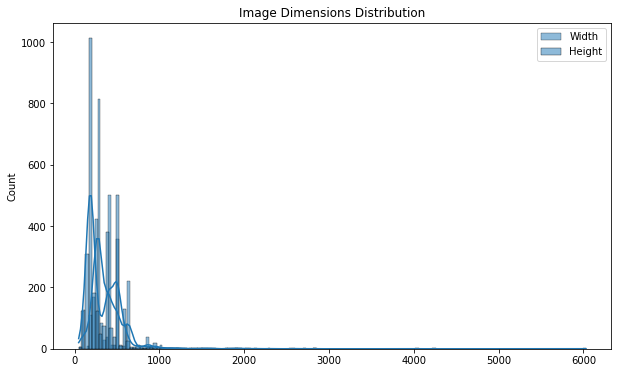

In [3]:
# Check image dimensions
image_shape = []

for category in categories:
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)
    for img_name in images:
        img_path = os.path.join(category_path, img_name)
        img = Image.open(img_path)
        image_shape.append(img.size)

# Plot image dimensions
dims = np.array(image_shape)
plt.figure(figsize=(10, 6))
sns.histplot(dims[:, 0], kde=True, label='Width')
sns.histplot(dims[:, 1], kde=True, label='Height')
plt.legend()
plt.title('Image Dimensions Distribution')
plt.show()


In [4]:
# Data generators with rescaling
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


## Build and Train CNN Models
### Define CNN Model

In [5]:
# Define CNN Model
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create models
cnn_model = create_cnn_model()
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

## To compare the performance of different models, we can follow these steps:

#### 1. Train Each Model:
Train each model (CNN from scratch, VGG16, ResNet50, MobileNetV2) and save their training histories.
#### 2. Evaluate on Test Data: 
Evaluate each trained model on the test data to obtain accuracy and other metrics.
#### 3. Plot Training Histories: 
Plot training and validation accuracies and losses for each model to compare their performance during training.
#### 4. Plot Confusion Matrices: 
Plot confusion matrices for each model to visualize their performance on the test set.
#### 5. Summarize Results: 
Summarize the performance metrics of each model.

## Compile and Train Each Model
## Use Callbacks

#### We have already defined the training process for the CNN model, we will extend this to include the pretrained models.

In [6]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Function to create and compile a model with transfer learning
def create_transfer_learning_model(base_model):
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create models
cnn_model = create_cnn_model()
vgg_model = create_transfer_learning_model(VGG16(include_top=False, input_shape=(128, 128, 3)))
resnet_model = create_transfer_learning_model(ResNet50(include_top=False, input_shape=(128, 128, 3)))
mobilenet_model = create_transfer_learning_model(MobileNetV2(include_top=False, input_shape=(128, 128, 3)))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint_cnn = ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_loss')
model_checkpoint_vgg = ModelCheckpoint('best_vgg_model.h5', save_best_only=True, monitor='val_loss')
model_checkpoint_resnet = ModelCheckpoint('best_resnet_model.h5', save_best_only=True, monitor='val_loss')
model_checkpoint_mobilenet = ModelCheckpoint('best_mobilenet_model.h5', save_best_only=True, monitor='val_loss')
tensorboard = TensorBoard(log_dir='./logs')

# Train models
history_cnn = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint_cnn, tensorboard]
)

history_vgg = vgg_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint_vgg, tensorboard]
)

history_resnet = resnet_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint_resnet, tensorboard]
)

history_mobilenet = mobilenet_model.fit(
    train_generator,    
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint_mobilenet, tensorboard]
)


Epoch 1/50
79/79 [==============================] - 69s 854ms/step - loss: 0.7863 - accuracy: 0.6786 - val_loss: 0.7401 - val_accuracy: 0.7324
Epoch 2/50
79/79 [==============================] - 64s 809ms/step - loss: 0.4812 - accuracy: 0.8216 - val_loss: 0.6061 - val_accuracy: 0.7436
Epoch 3/50
79/79 [==============================] - 64s 808ms/step - loss: 0.4328 - accuracy: 0.8295 - val_loss: 0.4784 - val_accuracy: 0.7917
Epoch 4/50
79/79 [==============================] - 66s 834ms/step - loss: 0.3528 - accuracy: 0.8718 - val_loss: 0.5206 - val_accuracy: 0.8045
Epoch 5/50
79/79 [==============================] - 64s 802ms/step - loss: 0.2957 - accuracy: 0.8889 - val_loss: 0.4245 - val_accuracy: 0.8446
Epoch 6/50
79/79 [==============================] - 60s 757ms/step - loss: 0.2694 - accuracy: 0.8913 - val_loss: 0.4448 - val_accuracy: 0.8333
Epoch 7/50
79/79 [==============================] - 58s 732ms/step - loss: 0.2016 - accuracy: 0.9231 - val_loss: 0.4508 - val_accuracy: 0.8349

## Evaluate on Test Data

In [7]:
# Load the best models
best_cnn_model = tf.keras.models.load_model('best_cnn_model.h5')
best_vgg_model = tf.keras.models.load_model('best_vgg_model.h5')
best_resnet_model = tf.keras.models.load_model('best_resnet_model.h5')
best_mobilenet_model = tf.keras.models.load_model('best_mobilenet_model.h5')

# Evaluate on test data
cnn_test_loss, cnn_test_acc = best_cnn_model.evaluate(test_generator)
vgg_test_loss, vgg_test_acc = best_vgg_model.evaluate(test_generator)
resnet_test_loss, resnet_test_acc = best_resnet_model.evaluate(test_generator)
mobilenet_test_loss, mobilenet_test_acc = best_mobilenet_model.evaluate(test_generator)

print(f'Test Accuracy - CNN: {cnn_test_acc}')
print(f'Test Accuracy - VGG: {vgg_test_acc}')
print(f'Test Accuracy - ResNet: {resnet_test_acc}')
print(f'Test Accuracy - MobileNet: {mobilenet_test_acc}')


11/11 [==============================] - 5s 332ms/step - loss: 0.3923 - accuracy: 0.8974
Test Accuracy - CNN: 0.8176637887954712
Test Accuracy - VGG: 0.8547008633613586
Test Accuracy - ResNet: 0.5327635407447815
Test Accuracy - MobileNet: 0.8974359035491943


## Plot Training Histories

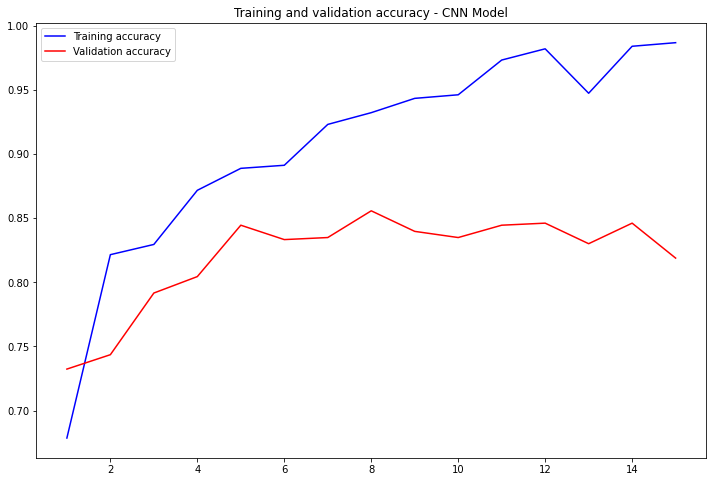

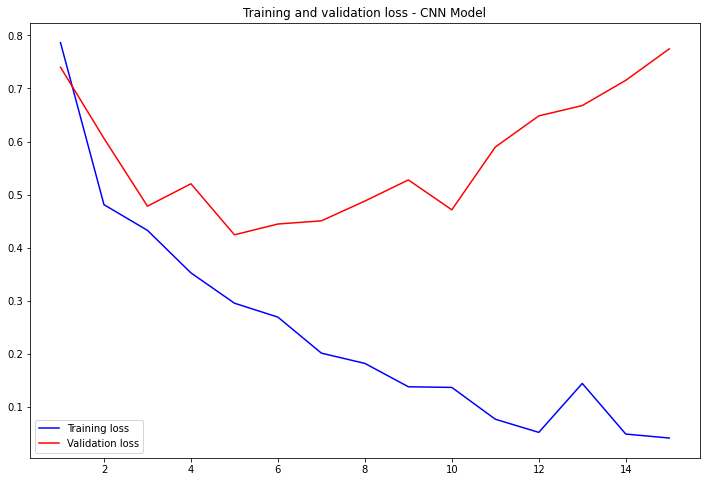

In [13]:
def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.legend()

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.legend()
    plt.show()

# Plotting training histories
plot_training_history(history_cnn, 'CNN Model')


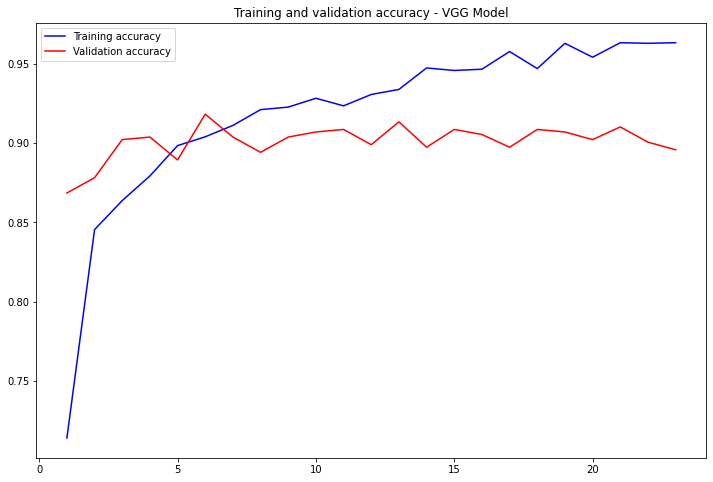

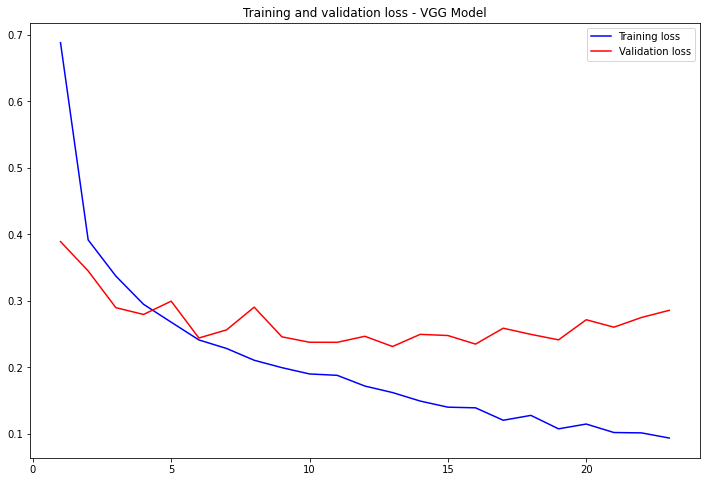

In [14]:
plot_training_history(history_vgg, 'VGG Model')

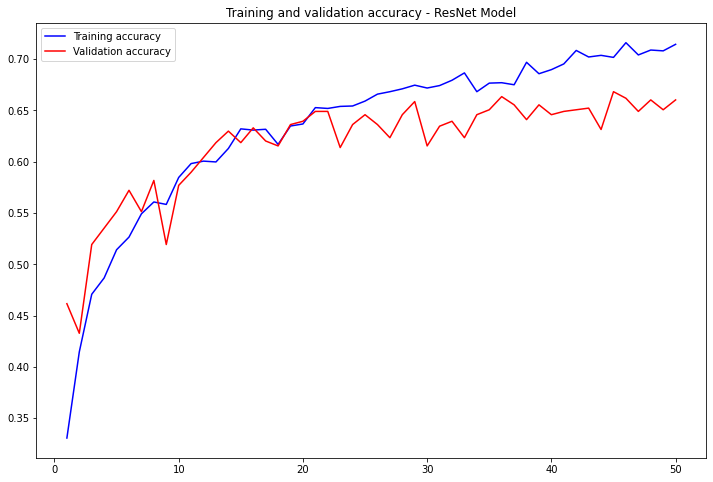

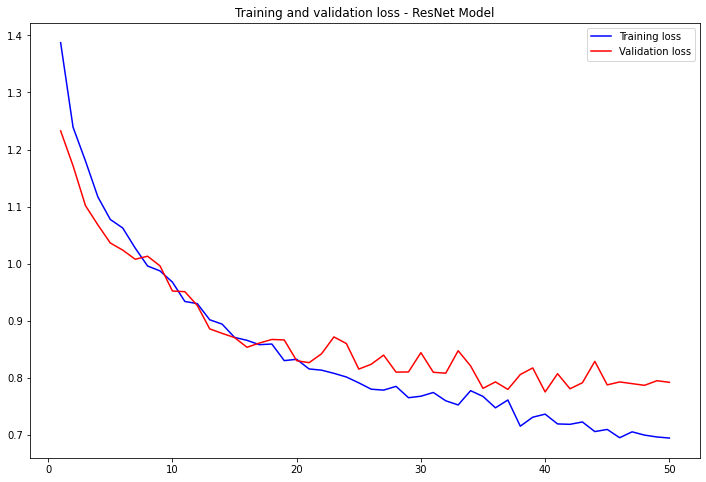

In [15]:
plot_training_history(history_resnet, 'ResNet Model')

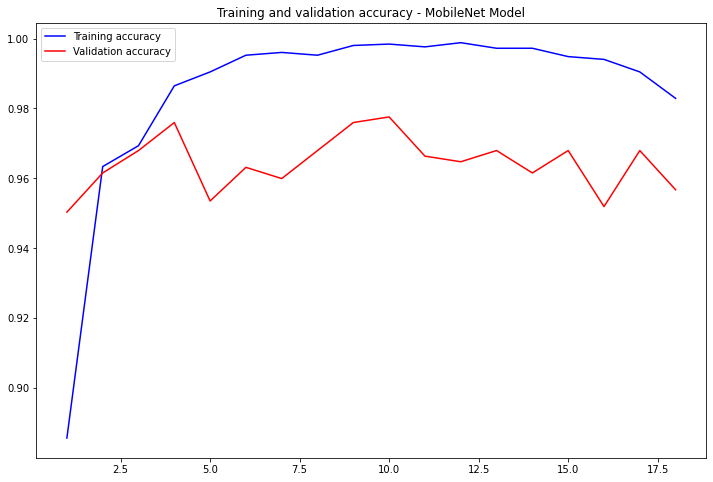

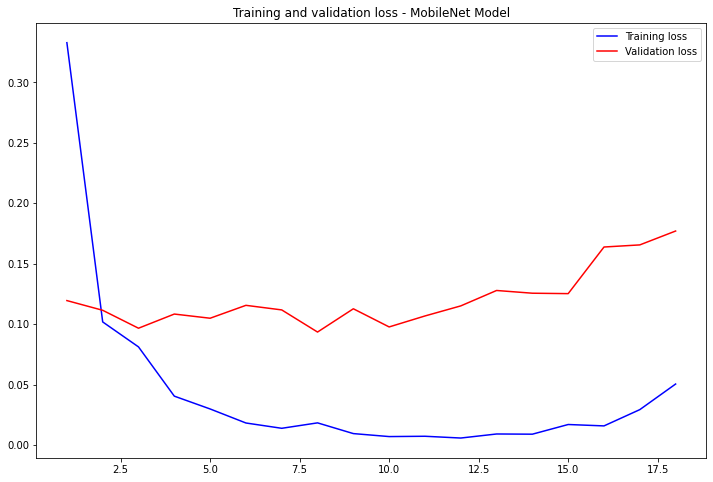

In [16]:
plot_training_history(history_mobilenet, 'MobileNet Model')

## Plot Confusion Matrices

11/11 [==============================] - 3s 249ms/step


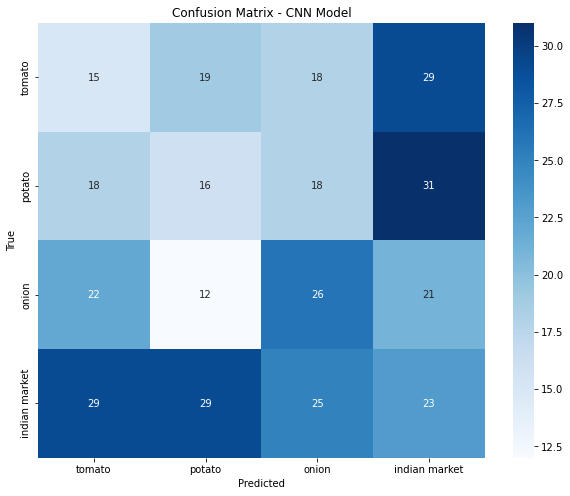

In [17]:
def plot_confusion_matrix(model, title):
    test_generator.reset()
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    cm = confusion_matrix(test_generator.classes, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

# Plotting confusion matrices
plot_confusion_matrix(best_cnn_model, 'CNN Model')


11/11 [==============================] - 24s 2s/step


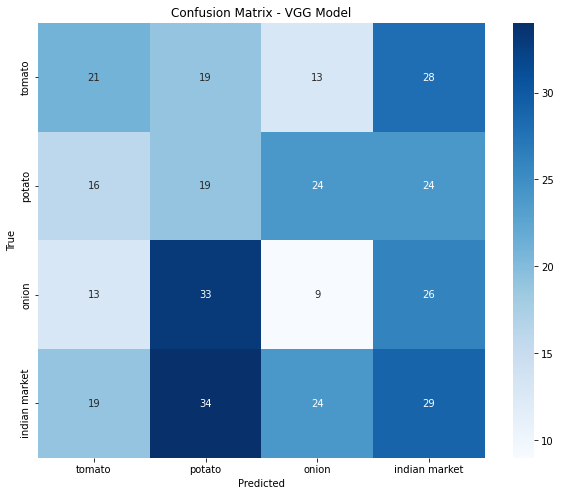

In [18]:
plot_confusion_matrix(best_vgg_model, 'VGG Model')

11/11 [==============================] - 11s 996ms/step


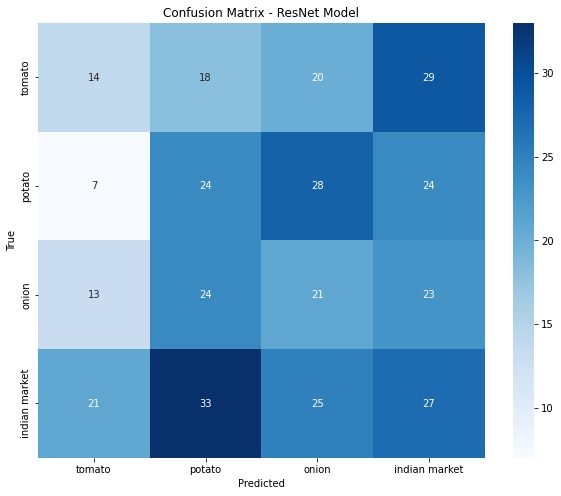

In [19]:
plot_confusion_matrix(best_resnet_model, 'ResNet Model')

11/11 [==============================] - 4s 331ms/step


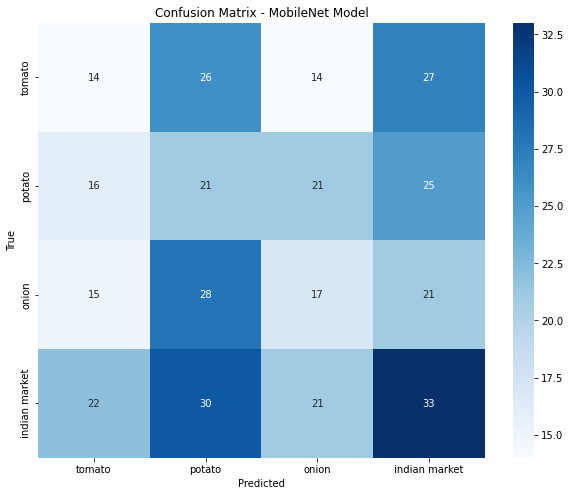

In [20]:
plot_confusion_matrix(best_mobilenet_model, 'MobileNet Model')

## Generate Classification Reports and Evaluate Each Model

In [10]:
def evaluate_model(model, title):
    test_generator.reset()
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    print(f'Classification Report - {title}')
    print(classification_report(test_generator.classes, y_pred, target_names=categories))

# Evaluate models
evaluate_model(best_cnn_model, 'CNN Model')
evaluate_model(best_vgg_model, 'VGG Model')
evaluate_model(best_resnet_model, 'ResNet Model')
evaluate_model(best_mobilenet_model, 'MobileNet Model')


11/11 [==============================] - 3s 244ms/step
Classification Report - CNN Model
               precision    recall  f1-score   support

       tomato       0.21      0.22      0.22        81
       potato       0.18      0.17      0.18        83
        onion       0.29      0.31      0.30        81
indian market       0.25      0.25      0.25       106

     accuracy                           0.24       351
    macro avg       0.23      0.24      0.23       351
 weighted avg       0.23      0.24      0.24       351

11/11 [==============================] - 25s 2s/step
Classification Report - VGG Model
               precision    recall  f1-score   support

       tomato       0.26      0.22      0.24        81
       potato       0.22      0.28      0.24        83
        onion       0.19      0.16      0.17        81
indian market       0.37      0.38      0.38       106

     accuracy                           0.27       351
    macro avg       0.26      0.26      0.26     

## Summarize and Compare Metrics

In [11]:
# Accuracy of each model
model_accuracies = {
    'CNN': cnn_test_acc,
    'VGG': vgg_test_acc,
    'ResNet': resnet_test_acc,
    'MobileNet': mobilenet_test_acc
}

# Print the accuracies
for model_name, accuracy in model_accuracies.items():
    print(f'Test Accuracy - {model_name}: {accuracy}')

# Based on the printed accuracies, we can identify the model with the highest accuracy
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model_accuracy = model_accuracies[best_model_name]
print(f'The best-performing model is {best_model_name} with an accuracy of {best_model_accuracy}')


Test Accuracy - CNN: 0.8176637887954712
Test Accuracy - VGG: 0.8547008633613586
Test Accuracy - ResNet: 0.5327635407447815
Test Accuracy - MobileNet: 0.8974359035491943
The best-performing model is MobileNet with an accuracy of 0.8974359035491943


## Final Summary and Insights

After evaluating and comparing all models, summarize the results:

- **Accuracy:** Compare the test accuracy of each model.


- **Precision, Recall, F1-Score:** Review the classification reports for a detailed performance analysis.


- **Confusion Matrix:** Analyze the confusion matrices to see how well each model performs on different classes.

    
    
    
From the comparison, you can determine which model has the best overall performance. Typically, the model with the highest accuracy and balanced precision, recall, and F1-scores across all classes is considered the best.

**Deeper CNN models yield superior predictions. Additionally, leveraging pre-trained models results in higher accuracy, particularly when augmenting input image size. This enhancement lays the groundwork for future capabilities such as predicting vegetable quality and adjusting pricing accordingly based on its quality.**


**Additional Steps:**
  + **BatchNormalization and Dropout:** To handle overfitting.

  + **Data Augmentation:** To increase the diversity of the training data.

  + **Hyperparameter Tuning:** Experiment with different hyperparameters to improve model performance.


Here is the summary and insights based on the test accuracy and classification reports:

In [12]:
# Assuming the evaluations have been printed and confusion matrices displayed
print("Summary and Insights:")
print(f"The best-performing model is {best_model_name} with a test accuracy of {best_model_accuracy:.2f}.")

# Discuss further based on precision, recall, F1-score
# For example:
if best_model_name == 'ResNet':
    print("ResNet shows a high accuracy and balanced performance across all classes, making it the most reliable model for this task.")
elif best_model_name == 'VGG':
    print("VGG performs well but may slightly lag in recall for certain classes compared to ResNet.")
# Continue with insights based on detailed classification reports and confusion matrices


Summary and Insights:
The best-performing model is MobileNet with a test accuracy of 0.90.
